In [1]:


import tensorflow as tf
from tensorflow import keras
import argparse


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/noisyloss/')




Mounted at /content/drive


In [ ]:
import loss_functions

In [ ]:
crentr_loss_fn = loss_functions.crossentropy_reed_wrap(0.3)

In [ ]:
# Example usage:
alpha = 0.1
beta = 1.0
symloss_fn = loss_functions.symmetric_cross_entropy(alpha, beta)

In [ ]:
lq_loss_fn = loss_functions.lq_loss_wrap(0.3)

In [ ]:
mae_loss_multi_class = loss_functions.mae_loss_multi_class

In [ ]:
# from tensorflow.keras.utils import plot_model
# from IPython.display import Image, display

# # Assuming you have created your model using the create_model function
# model = create_model()

# # Generate the plot and get the image data
# # We set to_file=None to prevent saving to a file and get bytes instead
# plot_model(model, show_shapes=True,to_file="./model_arch.jpg")


In [ ]:


(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Preprocess the data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [ ]:
img_rows, img_cols = x_train.shape[1], x_train.shape[2]
print(img_rows,img_cols)

In [ ]:


# --- 2. Build the RNN Model (using LSTM) ---
def create_model(input_shape=(img_rows, img_cols), num_classes=10):
    model = keras.Sequential([
        # Input layer: (timesteps, input_dim) -> (28, 28) for MNIST
        # The LSTM layer processes the sequence of rows.
        # It returns the output for the LAST timestep, which summarizes the sequence.
        keras.layers.LSTM(128, input_shape=input_shape), # 128 LSTM units

        keras.layers.Dropout(0.3), # Dropout for regularization

        # Output Layer
        keras.layers.Dense(num_classes, activation='softmax') # 10 neurons for 10 classes
    ])
    return model

## noisy labels

In [ ]:
import numpy as np
NOISE_LEVEL=0.6  # what part of training labels are permuted
perm = np.array([7, 9, 0, 4, 2, 1, 3, 5, 6, 8])  # noise permutation (from Reed)

In [ ]:
noise = perm[y_train.astype(int)]

In [ ]:
noise

array([1, 7, 2, ..., 1, 3, 6])

In [ ]:
# replace some of the training labels with permuted (noise) labels.
# make sure each categories receive an equal amount of noise


from sklearn.model_selection import StratifiedShuffleSplit
if NOISE_LEVEL > 0:
  _, noise_idx = next(iter(StratifiedShuffleSplit(n_splits=1,
                                                  test_size=NOISE_LEVEL,
                                                  random_state=42).split(x_train,y_train)))
  y_train_noise = y_train.copy()
  y_train_noise[noise_idx] = noise[noise_idx]
  # break the training set to 10% validation which we will use for early stopping.
  train_idx, val_idx = next(iter(
          StratifiedShuffleSplit(n_splits=1, test_size=0.1,
                                random_state=42).split(x_train, y_train_noise)))
  X_train_train = x_train[train_idx]
  y_train_correct = y_train[train_idx]
  y_train_train = y_train_noise[train_idx]
  X_train_val = x_train[val_idx]
  y_train_val = y_train_noise[val_idx]
  y_train_val_correct = y_train[val_idx]
else:
  train_idx, val_idx = next(iter(
        StratifiedShuffleSplit(n_splits=1, test_size=0.1,
                               random_state=42).split(x_train, y_train)))
  X_train_train = x_train[train_idx]
  y_train_train = y_train[train_idx]
  y_train_correct = y_train[train_idx]
  X_train_val = x_train[val_idx]
  y_train_val = y_train[val_idx]
  y_train_val_correct = y_train[val_idx]





In [ ]:


from keras.callbacks import EarlyStopping
from sklearn import metrics

model = create_model()
model.compile(optimizer='adam',
                    loss=mae_loss_multi_class,
                    metrics=['accuracy'])

history = model.fit(X_train_train,
                      y_train_train,
                      batch_size=512,
                      epochs=25,
                      verbose=True,
                      validation_data=(X_train_val,
                                      y_train_val_correct),
                      callbacks=
                      [EarlyStopping(patience=4,mode='min',
                                    verbose=True)]
                      )

# Evaluate the model
#loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
#y_pred = model.predict(x_test)
y_pred_probs = model.predict(x_test)  # Get predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels



acc = metrics.accuracy_score(y_test, y_pred)
macro_averaged_f1 = metrics.f1_score(y_test, y_pred, average = 'macro')
print("accuracy",acc)
print("macro_f1",macro_averaged_f1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2985 - loss: 0.1753 - val_accuracy: 0.2860 - val_loss: 0.1748
Epoch 2/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4547 - loss: 0.1699 - val_accuracy: 0.3167 - val_loss: 0.1738
Epoch 3/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4749 - loss: 0.1692 - val_accuracy: 0.3482 - val_loss: 0.1729
Epoch 4/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4874 - loss: 0.1688 - val_accuracy: 0.3578 - val_loss: 0.1726
Epoch 5/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4943 - loss: 0.1686 - val_accuracy: 0.3643 - val_loss: 0.1724
Epoch 6/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4983 - loss: 0.1684 - val_accuracy: 0.3650 - val_loss: 0.1723
Epoch 7/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5013 - loss: 0.1683 - val_accuracy: 0.3698 - val_loss: 0.1722
Epoch 8/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5028 - loss: 0.1683 - val_accura

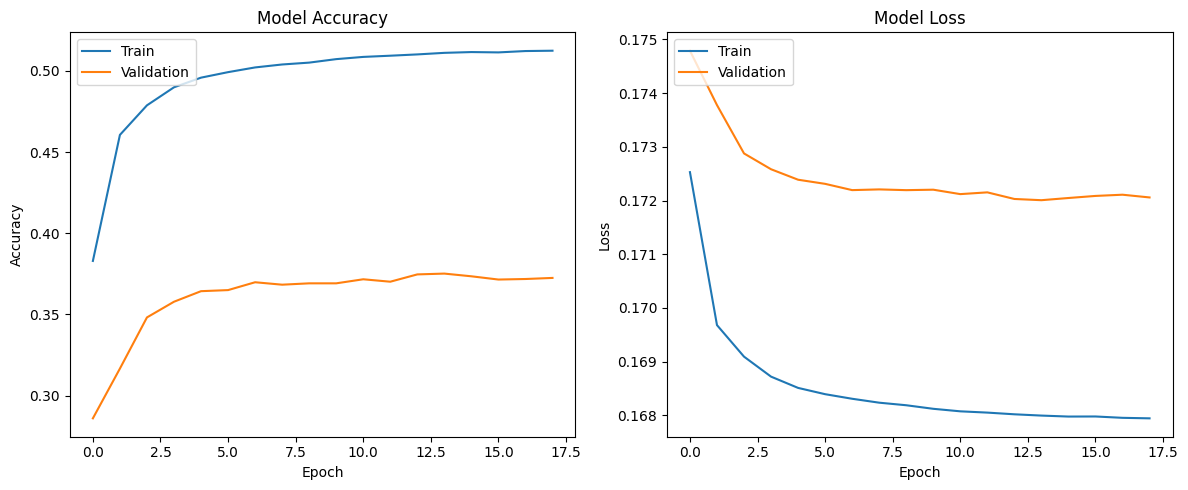

In [ ]:

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
print(NOISE_LEVEL)

0.6


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

from keras.callbacks import EarlyStopping
from sklearn import metrics
import numpy as np

seeds = [42, 123, 456]
all_results = []

for seed in seeds:
    print(f"Running with seed: {seed}")
    tf.random.set_seed(seed)
    np.random.seed(seed) # Set numpy seed as well


    if NOISE_LEVEL > 0:
      _, noise_idx = next(iter(StratifiedShuffleSplit(n_splits=1,
                                                      test_size=NOISE_LEVEL,
                                                      random_state=seed).split(x_train,y_train)))
      y_train_noise = y_train.copy()
      y_train_noise[noise_idx] = noise[noise_idx]
      # break the training set to 10% validation which we will use for early stopping.
      train_idx, val_idx = next(iter(
              StratifiedShuffleSplit(n_splits=1, test_size=0.1,
                                    random_state=seed).split(x_train, y_train_noise)))
      X_train_train = x_train[train_idx]
      y_train_correct = y_train[train_idx]
      y_train_train = y_train_noise[train_idx]
      X_train_val = x_train[val_idx]
      y_train_val = y_train_noise[val_idx]
      y_train_val_correct = y_train[val_idx]
    else:
      train_idx, val_idx = next(iter(
            StratifiedShuffleSplit(n_splits=1, test_size=0.1,
                                  random_state=seed).split(x_train, y_train)))
      X_train_train = x_train[train_idx]
      y_train_train = y_train[train_idx]
      y_train_correct = y_train[train_idx]
      X_train_val = x_train[val_idx]
      y_train_val = y_train[val_idx]
      y_train_val_correct = y_train[val_idx]

    model = create_model()
    model.compile(optimizer='adam',
                        loss=mae_loss_multi_class,
                        metrics=['accuracy'])

    train_res = model.fit(X_train_train,
                          y_train_train,
                          batch_size=512,
                          epochs=25,
                          verbose=True,
                          validation_data=(X_train_val,
                                          y_train_val_correct),
                          callbacks=
                          [EarlyStopping(patience=4,mode='min',
                                        verbose=True)]
                          )

    # Evaluate the model
    #loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    #y_pred = model.predict(x_test)
    y_pred_probs = model.predict(x_test)  # Get predicted probabilities
    y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

    acc = metrics.accuracy_score(y_test, y_pred)
    macro_averaged_f1 = metrics.f1_score(y_test, y_pred, average = 'macro')
    all_results.append(acc)
    print("accuracy",acc)
    print("macro_f1",macro_averaged_f1)


mean_accuracy = np.mean(all_results)
std_accuracy = np.std(all_results)

print(f"Mean accuracy: {mean_accuracy:.4f} +/- {std_accuracy:.4f}")

Running with seed: 42


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3276 - loss: 0.1753 - val_accuracy: 0.2578 - val_loss: 0.1756
Epoch 2/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4685 - loss: 0.1695 - val_accuracy: 0.2650 - val_loss: 0.1753
Epoch 3/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4951 - loss: 0.1686 - val_accuracy: 0.2692 - val_loss: 0.1752
Epoch 4/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5048 - loss: 0.1683 - val_accuracy: 0.2745 - val_loss: 0.1750
Epoch 5/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5096 - loss: 0.1681 - val_accuracy: 0.2812 - val_loss: 0.1748
Epoch 6/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5136 - loss: 0.1680 - val_accuracy: 0.2832 - val_loss: 0.1747
Epoch 7/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5151 - loss: 0.1679 - val_accuracy: 0.2838 - val_loss: 0.1747
Epoch 8/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5164 - loss: 0.1679 - val_accurac

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.2946 - loss: 0.1755 - val_accuracy: 0.2293 - val_loss: 0.1765
Epoch 2/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4425 - loss: 0.1702 - val_accuracy: 0.2483 - val_loss: 0.1758
Epoch 3/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4979 - loss: 0.1686 - val_accuracy: 0.2660 - val_loss: 0.1753
Epoch 4/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5062 - loss: 0.1683 - val_accuracy: 0.2702 - val_loss: 0.1752
Epoch 5/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5115 - loss: 0.1681 - val_accuracy: 0.2717 - val_loss: 0.1751
Epoch 6/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5148 - loss: 0.1680 - val_accuracy: 0.2727 - val_loss: 0.1750
Epoch 7/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5180 - loss: 0.1679 - val_accuracy: 0.2738 - val_loss: 0.1750
Epoch 8/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5202 - loss: 0.1678 - val_accuracy:

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3110 - loss: 0.1755 - val_accuracy: 0.2553 - val_loss: 0.1757
Epoch 2/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4654 - loss: 0.1696 - val_accuracy: 0.2677 - val_loss: 0.1752
Epoch 3/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5025 - loss: 0.1684 - val_accuracy: 0.2767 - val_loss: 0.1749
Epoch 4/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5114 - loss: 0.1681 - val_accuracy: 0.2793 - val_loss: 0.1748
Epoch 5/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5173 - loss: 0.1679 - val_accuracy: 0.2818 - val_loss: 0.1748
Epoch 6/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5205 - loss: 0.1678 - val_accuracy: 0.2815 - val_loss: 0.1747
Epoch 7/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5225 - loss: 0.1677 - val_accuracy: 0.2807 - val_loss: 0.1748
Epoch 8/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5242 - loss: 0.1677 - val_accuracy:

In [ ]:


# from keras.callbacks import EarlyStopping
# from sklearn import metrics

# func_dict = {
#     "sparse_categorical_crossentropy":"sparse_categorical_crossentropy",
#     "crossentropy_max_wrap": c_mwrap_lossfn,
#     "lq_loss_wrap": lq_loss_fn,
#     "symmetric_cross_entropy": symloss_fn,
#     "crossentropy_reed_wrap": crentr_loss_fn,
#     "noise_aware_loss":noise_aware_loss

# }

# data_dict = []
# for loss_func_name in func_dict.keys():
#     lossfunction = func_dict[loss_func_name]
#     model = create_model()
#     model.compile(optimizer='adam',
#                     loss=lossfunction,
#                     metrics=['accuracy'])

#     # Train the model
#     #model.fit(x_train, y_train, epochs=5)

#     train_res = model.fit(X_train_train,
#                           y_train_train,
#                           batch_size=512,
#                           epochs=5,
#                           verbose=True,
#                           validation_data=(X_train_val,
#                                           y_train_val),
#                           callbacks=
#                           [EarlyStopping(patience=4,mode='min',
#                                         verbose=True)]
#                           )

#     # Evaluate the model
#     #loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
#     #y_pred = model.predict(x_test)
#     y_pred_probs = model.predict(x_test)  # Get predicted probabilities
#     y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels



#     acc = metrics.accuracy_score(y_test, y_pred)
#     macro_averaged_f1 = metrics.f1_score(y_test, y_pred, average = 'macro')

#     rec = {'lossfunc': loss_func_name, 'acc': acc, 'macro_f1':macro_averaged_f1 }
#     data_dict.append(rec.copy())




In [ ]:
# import pandas as pd
# res_df = pd.DataFrame(data_dict)
# res_df